# 루프 워크 플로 구현 : 숫자 맞추기 게임

In [ ]:
# 순환하는 그래프 구조 만들어 보기
# 조건이 만족할때 까지 루프를 실행하는 워크플로

# 기존의 상태기반 라우팅을 사용하여 구현.
# 루프패턴은 '대화형 애플리케이션', '재시도 로직', '반복 작업' 등에 활용.

# import

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing import Dict, Any, Literal
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
import random
from IPython.display import Image, display

# 상태 정의

In [3]:
class GuessGameState(BaseModel):
    target_number: int = Field(default=0, description="맞춰야 할 숫자")
    user_guess: int = Field(default=0, description="사용자 추측")
    attempts: int = Field(default=0, description="시도 횟수")
    max_attempts: int = Field(default=5, description="최대 시도 횟수")
    game_status: str = Field(default="playing", description="게임 상태")
    response: str = Field(default="", description="응답 메시지")    

# 게임 설정 노드

In [4]:
def game_setup(state: GuessGameState) -> Dict[str, Any]:
    target = random.randint(1, 50)
    print('✅게임 시작!')

    return {
        'target_number': target,
        'game_status': "playing",
        "response": f'1~50 사이의 숫자를 맞춰보세요! (최대 {state.max_attempts}회)',
        "attempts": 0,
    }

# 게임 상태에 따른 분기 처리

In [ ]:
"""
② 게임 상태에 따른 분기 처리: game_status 필드를 통해 게임의 현재 상태를 추적합니다. 
"playing", "won", "lost" 상태로 게임 진행을 제어합니다. 
이 상태는 라우팅 함수에서 다음 경로를 결정하는 데 사용됩니다
"""
None

## 사용자 추측 노드

In [11]:
def user_guess(state: GuessGameState) -> Dict[str, Any]:
    guess = input("입력: ")  # 사용자 입력
    print(f"[{state.attempts + 1} 번째 시도] 추출: {guess}")

    return {"user_guess": int(guess), "attempts": state.attempts + 1}

## 추측 확인 노드

In [12]:
def check_guess(state: GuessGameState) -> Dict[str, Any]:
    target = state.target_number
    guess = state.user_guess
    attempts = state.attempts

    print(f"[check_guess] {guess} (시도: {attempts}회)")

    # 게임 상태에 따른 분기 처리
    if guess == target:
        print('❤정답!')
        return {
            "game_status": "won",
            "response": f"정답! {guess}를 {attempts} 번 안에 맞췄습니다."
        }

    elif attempts >= state.max_attempts:
        print("💥시도 횟수 초과!")
        return {
            "game_status": "lost",
            "response": f"게임 종료! 정답은 {target} 이었습니다",
        }

    else:
        # 힌트 주기
        hint = "더 큰 수" if guess < target else "더 작은 수"
        remaining = state.max_attempts - attempts
        print(f"계속 진행: {hint}")
        return {
            "game_status": "playing",
            "response": f"{guess}는 틀렸습니다. {hint}를 시도해보세요! (남은기회: {remaining}회)",  
        }
        

    

# 조건부 라우팅 함수

In [13]:
"""
④ 조건부 라우팅 함수: 루프 구현의 핵심이라 할 수 있는 조건부 라우팅 함수입니다. 
게임의 상태가 "playing" 인 경우 "continue"가 되며 이는 루프를 계속 반복합니다. 
게임이 플레이 중이 아니라면 "end"를 반환하고 루프를 종료합니다.
"""
None

In [14]:
def route_game(state: GuessGameState) -> Literal["continue", "end"]:
    print(f"라우팅 체크: 상태={state.game_status}, 시도={state.attempts}")
    if state.game_status == "playing":
        return "continue"
    else:
        return "end"

# 그래프 생성: 루프 워크플로

In [15]:
def create_guess_game_graph():
    workflow = StateGraph(GuessGameState)

    workflow.add_node("setup", game_setup)
    workflow.add_node("guess", user_guess)
    workflow.add_node("check", check_guess)

    workflow.add_edge(START, "setup")
    workflow.add_edge("setup", "guess")
    workflow.add_edge("guess", "check")

    # 조건부 엣지 - 동적 라우팅으로 루프 구현
    workflow.add_conditional_edges(
        "check", 
        route_game, 
        {
            "continue": "guess",  # 게임 계속 -> 다시 추측 (루프!)
            "end": END,   # 게임 종료 -> 끝
        }
    )

    return workflow.compile()

    

# 실행

In [17]:
app = create_guess_game_graph()

initial_state = GuessGameState(max_attempts=5)
result = app.invoke(initial_state)

print(f"\n최종결과: {result['response']}")
print(f"게임 상태: {result['game_status']}")
print(f"총 시도: {result['attempts']}회")



✅게임 시작!


입력:  25


[1 번째 시도] 추출: 25
[check_guess] 25 (시도: 1회)
계속 진행: 더 작은 수
라우팅 체크: 상태=playing, 시도=1


입력:  13


[2 번째 시도] 추출: 13
[check_guess] 13 (시도: 2회)
❤정답!
라우팅 체크: 상태=won, 시도=2

최종결과: 정답! 13를 2 번 안에 맞췄습니다.
게임 상태: won
총 시도: 2회


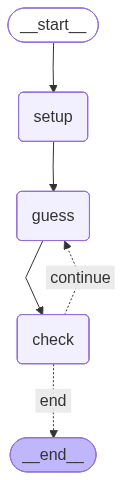

In [18]:
Image(app.get_graph().draw_mermaid_png())